<a href="https://colab.research.google.com/github/jshin13/MindX_time-series_analysis/blob/main/MindX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import zipfile
import urllib.request
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dirpath = '/content/drive/MyDrive/MindX_Data/Optical Imaging System Data Sets/'
fpath = 'offaxis_10_27_2020/tf'
# fpath = 'offaxis_11_12_2020/tf'

In [3]:
import tensorflow as tf
from pathlib import Path

def load_dataset(path):
    return (tf.data.Dataset.list_files(str(Path(path) / '*'), shuffle=False)
        # Note: cycle_length=1 ensures that sessions are loaded sequentially.
        # If sessions can be intermingled, then cycle_length can be increased for better performance.
        .interleave(_load_session, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE)
    )

@tf.function
def _load_session(path):
    return tf.data.experimental.load(
        path,
        dict(
            data=tf.TensorSpec((None, None), dtype=tf.float32),
            time=tf.TensorSpec((), dtype=tf.float64),
            stimulus=tf.TensorSpec((), dtype=tf.bool),
            dataset=tf.TensorSpec((), dtype=tf.string),
            ekg=tf.TensorSpec((), dtype=tf.float32),
            ppg=tf.TensorSpec((), dtype=tf.float32),
        ),
    )

ds = load_dataset(dirpath + fpath)
ds

<ParallelInterleaveDataset shapes: {data: (None, None), time: (), stimulus: (), dataset: (), ekg: (), ppg: ()}, types: {data: tf.float32, time: tf.float64, stimulus: tf.bool, dataset: tf.string, ekg: tf.float32, ppg: tf.float32}>

In [116]:
# mat file loader (work in progress)

# import h5py

# dirpath = '/content/drive/MyDrive/MindX_Data/Optical Imaging System Data Sets/'
# fpath = 'offaxis_10_27_2020/mat/'

# newpath = dirpath + fpath + 'AQ.mat'

# f = h5py.File(newpath,'r')
# # data = f.get('data/variable1')
# # data = np.array(data) # For converting to a NumPy array
# f.keys()
# # f['cam']
# for i, j in f.items():
#     print (i,j)

In [179]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from scipy import signal
# from IPython.display import clear_output
import pickle
import os

In [103]:
%pip install hyppo
import hyppo

In [104]:
def compute_ROI(ds1):

    origin = [0.5, 0.5]
    radius = 0.3
    holograms = tf.convert_to_tensor(ds1, tf.float32)
    shape = [64, 64]#tf.shape(holograms)[1:]

    x, y = tf.meshgrid(
        tf.linspace(0. - origin[0], 1. - origin[0], shape[0]),
        tf.linspace(0. - origin[1], 1. - origin[1], shape[1]),
    )
    grid = tf.sqrt(x**2 + y**2)
    mask = grid <= radius

    region = tf.boolean_mask(holograms, mask, axis=0)
    mean = tf.math.reduce_mean(region, axis=-1)

    return mean, mask

In [105]:
filename = 'ds.pickle'

if os.path.exists(filename):
    with open(filename, 'rb') as f:
        ds1 = pickle.load(f, encoding='bytes')
else:
    ds1 = [[],[],[],[],[],[],[]]

    for idx, data in enumerate(tqdm(ds)):
        # if data['dataset'] == bytes(b'AQ'):
        temp = data['data'].numpy()
        # ds1[0].append(temp)
        ds1[1].append(data['time'].numpy())
        ds1[2].append(data['stimulus'].numpy())
        ds1[3].append(data['dataset'].numpy())
        ds1[4].append(data['ekg'].numpy())
        ds1[5].append(data['ppg'].numpy())
        roi, _ = compute_ROI(temp) # compute ROI for all range
        ds1[6].append(roi.numpy())

    with open(filename, 'wb') as f:
        pickle.dump(ds1, f)

In [126]:
# data, time, stimulus, dataset, ekg, ppg

In [153]:
for data in ds:
    mean, mask = compute_ROI(data['data'].numpy())
    sample_data = data['data'].numpy()
    break

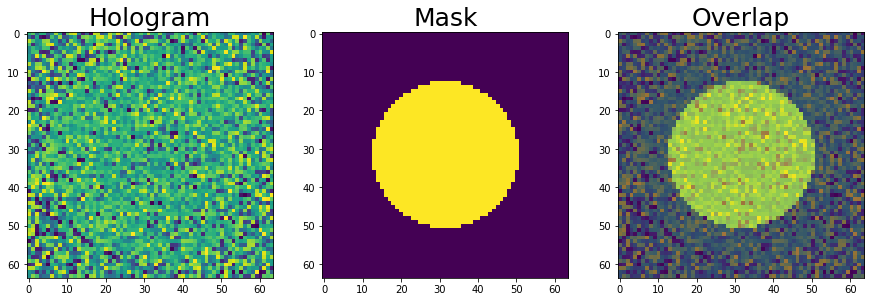

In [155]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.imshow(sample_data)
ax2.imshow(mask)

ax3.imshow(sample_data)
ax3.imshow(mask, alpha=0.5)

labels = ['Hologram', 'Mask', 'Overlap']

for i, lab in enumerate((ax1,ax2,ax3)):
    lab.set_title(labels[i], fontsize=25)

fig.savefig('hologram_mask.png', bbox_inches='tight')

In [160]:
ds1 = np.array(ds1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [168]:
for i in ds1:
    try: print(i[0])
    except: print([])

[]
0.000227
False
b'AQ'
-0.020156119
-0.17671353
95.45412


In [169]:
# only one dataset type
set(ds1[3])

{b'AQ', b'AR', b'AS', b'AT', b'AU', b'AV', b'AW', b'AX', b'AY', b'AZ'}

In [170]:
# binarize boolean
t = np.array(ds1[2])+0

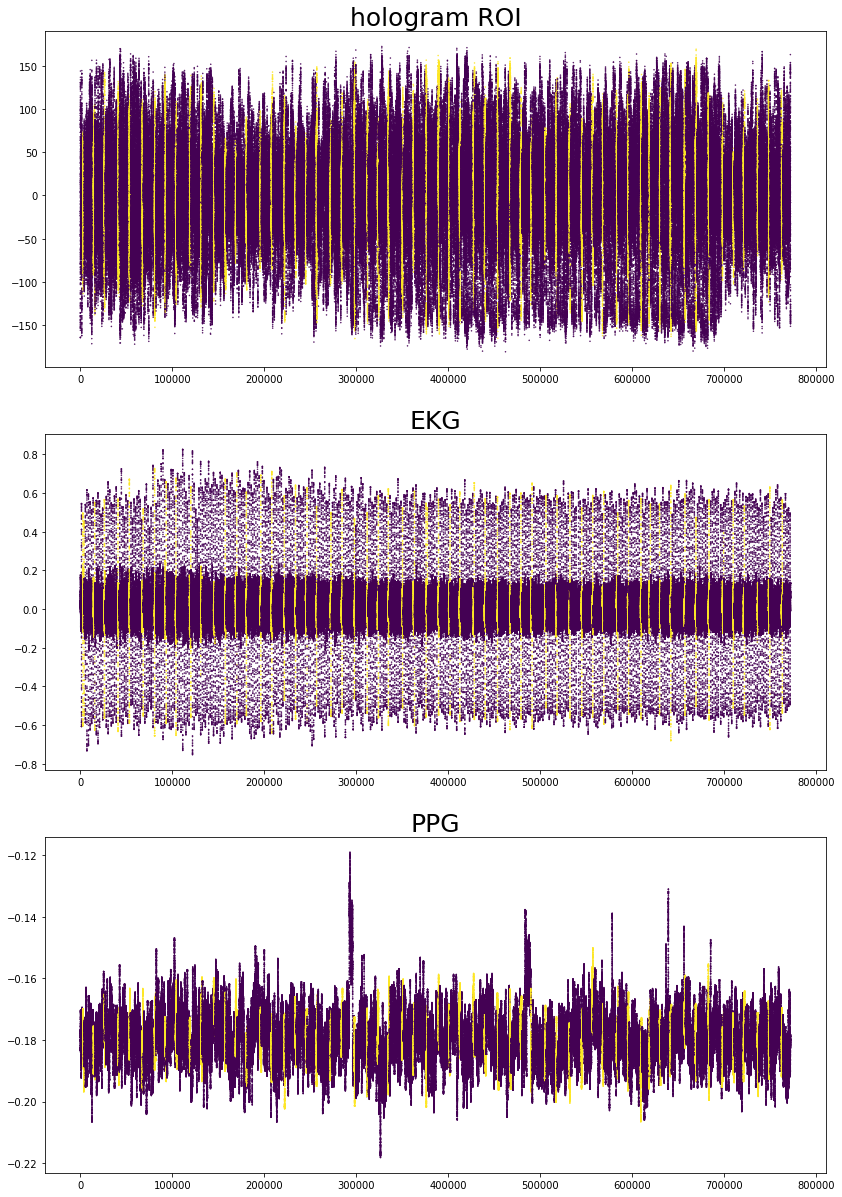

In [172]:
t_i = np.arange(0,len(ds1[1]))

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(14,7*3))
# plt.figure(figsize=(14,7))

# plt.scatter(t_i, ds1[4], ls='-', marker='.', s=1, c=t)
# plt.scatter(t_i, ds1[5], ls='-', marker='.', s=1, c=t)
# plt.scatter(t_i, ds1[6], ls='-', marker='.', s=1 ,c=t)

ax1.scatter(t_i, ds1[6], ls='-', marker='.', s=1, c=t)
ax2.scatter(t_i, ds1[4], ls='-', marker='.', s=1, c=t)
ax3.scatter(t_i, ds1[5], ls='-', marker='.', s=1, c=t)

labels = ['hologram ROI', 'EKG', 'PPG']

for i, lab in enumerate((ax1,ax2,ax3)):
    lab.set_title(labels[i], fontsize=25)

fig.savefig('data_visualization.png', bbox_inches='tight')

In [173]:
# abnormality in time variable
# fig, (ax1) = plt.subplots(1,1, figsize=(10,5))

# ax1.plot(ds1[6])
# # ax1.plot(ds1[1])
# # ax1.plot(ds1[1])
# # ax2.plot(ds1[1][113100:113200])
# # ax3.plot(ds1[1][4450:4500])
# ax1.set_ylabel('Time stamp')

# fig.savefig('time.png', bbox_inches='tight')

In [174]:
new_ds = np.array([])
new_ds = [[] for i in range(7)]

for i, dat in enumerate(ds1):
    new_ds[i] = np.array(dat)

In [175]:
# binarize boolean
new_ds[2] = new_ds[2] + 0
new_ds[2]

array([0, 0, 0, ..., 0, 0, 0])

In [176]:
# length of one session
new_ds[1][idx].shape

(77353,)

In [177]:
# data, time, stimulus, dataset, ekg, ppg
ds_by_session = [[] for i in range(10)]

for i, b_id in enumerate(set(new_ds[3])):
    idx = new_ds[3] == b_id
    ds_by_session[i].append(new_ds[1][idx]) #time
    ds_by_session[i].append(new_ds[2][idx]) #stimulus
    ds_by_session[i].append(new_ds[4][idx]) #ekg
    ds_by_session[i].append(new_ds[5][idx]) #ppg                           
    ds_by_session[i].append(new_ds[6][idx]) #hologram ROI                           

In [178]:
ds_by_session[0][0][ds_by_session[0][1] == 1].shape
ds_by_session[0][2][ds_by_session[0][1] == 1].shape
ds_by_session[0][3][ds_by_session[0][1] == 1].shape

(9471,)

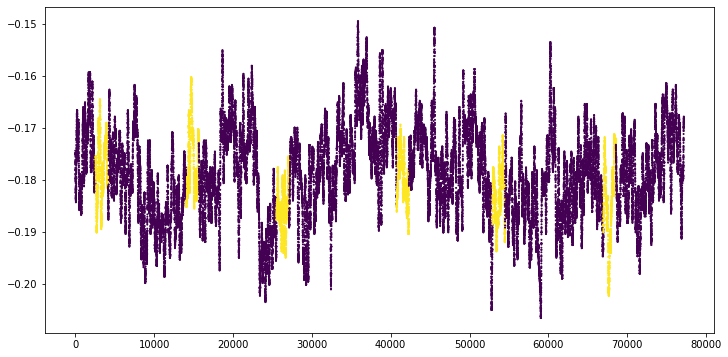

In [142]:
# resampling signal to match baseline
plt.figure(figsize=(12,6))
x_i = np.arange(0,ds_by_session[0][0].size)
plt.scatter(x_i, ds_by_session[0][3], c=ds_by_session[0][1], linestyle='-', s=1)

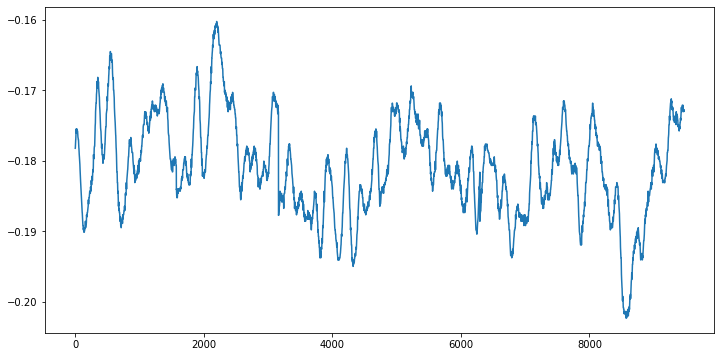

In [143]:
plt.figure(figsize=(12,6))
plt.plot(signal.resample(ds_by_session[0][3][ds_by_session[0][1] == 1], 9471))

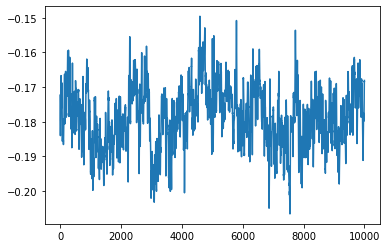

In [138]:
plt.plot(signal.resample(ds_by_session[0][3][ds_by_session[0][1] == 0], 10000))

In [ ]:
# data, time, stimulus, dataset, ekg, ppg

In [136]:
stop here

SyntaxError: ignored

In [44]:
# ds1[6]
new_ds = np.array(ds1[6])

In [79]:
new_ds.shape
# ds1[3] == bytes(b'AQ')
ds1[3] = np.array(ds1[3])

In [85]:
boolidx = ds1[3] == bytes(b'AQ')
new_ds[boolidx[:-1]].shape
# ds1[3] == bytes(b'AQ')

(77272,)

In [101]:

ds_by_session[0][0][ds_by_session[0][1] == 1].shape
ds_by_session[0][2][ds_by_session[0][1] == 1].shape
ds_by_session[0][3][ds_by_session[0][1] == 1].shape
dcorr_time.test(np.array([[1],[2]]),np.array([[1],[2],[3]]))

ValueError: ignored

In [100]:
dcorr = hyppo.independence.Dcorr()
dcorr_time = hyppo.time_series.DcorrX()
# dcorr.test(x=ds1[0],y=ds1[1]), dcorr.test(x=ds1[0],y=ds1[2])

In [98]:
mgc = hyppo.independence.MGC()
# mgc.test(x=ds1[0],y=ds1[1]), mgc.test(x=ds1[1],y=ds1[2])

In [ ]:
kmerf = hyppo